<a href="https://colab.research.google.com/github/Ollie-Morris/Ollie-Morris/blob/main/Demixing_geometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

np.random.seed(42)


In [36]:
# Synthetic Data
number_data_points = 10000
number_data_points = 1000000

lifetime1 = 10
lifetime2 = 6

pi1 = .7  # Mixing proportion for the first exponential distribution
pi2 = 1 - pi1

dt = 5  #The time interval giving us the time resolution

# Generate samples
samples = np.zeros(number_data_points)
for i in range(number_data_points):
  # Determine which distribution is sampled from
  if np.random.rand() < pi1:
    dw_time = np.random.exponential(lifetime1) #dwell time unbinned
    samples[i] = np.ceil(dw_time/dt) # Integer collection time, in units of dt, starting at 1
  else:
    dw_time = np.random.exponential(lifetime2)
    samples[i] = np.ceil(dw_time/dt)


In [37]:
#Calculating the effective geometric distribution in `success probability`
rho1 = 1-np.exp(-dt/lifetime1)
rho2 = 1-np.exp(-dt/lifetime2)

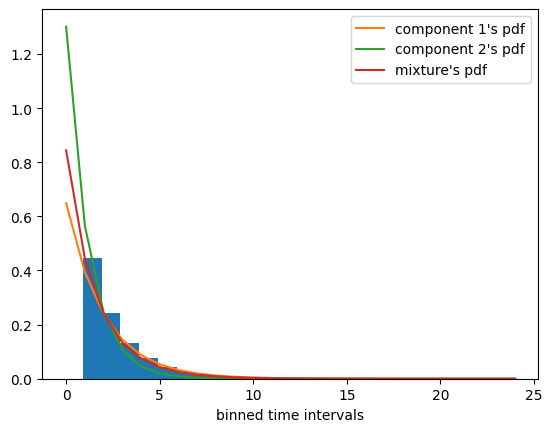

In [38]:
def geometric_logprob(k,rho):
    return np.log(rho) + np.log(1-rho)*(k-1) #consistent with starting at 1

k = np.arange(np.max(samples))
p1 = np.exp(geometric_logprob(k,rho1))
p2 = np.exp(geometric_logprob(k,rho2))
p = pi1 * p1 + pi2 * p2

plt.hist(samples, bins=k-.1, density=True)
plt.plot(k, p1)
plt.plot(k, p2)
plt.plot(k, p)
plt.xlabel("binned time intervals")

plt.legend(["component 1's pdf", "component 2's pdf", "mixture's pdf"])

Some repetition, but just so the two pieces of the code can run independently

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln, logsumexp
from tqdm import tqdm

In [40]:
#dt = 1
scale = 50

large_M = 2
dir_conc = np.ones(large_M)/large_M

In [41]:

def geometric_logprob(k, rho):
  return np.log(rho) + (k - 1) * np.log(1 - rho)

def geometricmix_logprob(k,rho,pi):
  per_component = geometric_logprob(k,rho.reshape(-1,1)) + np.log(pi).reshape(-1,1)
  return logsumexp(per_component, axis=0)

def gamma_logprob(x, alpha, theta):
    return -gammaln(alpha) - alpha * np.log(theta) + (alpha - 1) * np.log(x) - x / theta

def dir_logprob(pi,conc):
    pi = np.clip(pi, epsilon, 1 - epsilon)
    dir_log_norm_const = gammaln(np.sum(conc)) - np.sum(gammaln(conc))
    return np.sum((conc - 1) * np.log(pi)) + dir_log_norm_const

In [42]:
dir_alpha = 10
dir_decay = .75
dir_beta = ((dir_decay)**np.arange(large_M))
dir_conc = dir_alpha * dir_beta/np.sum(dir_beta)
epsilon = 1e-5  # avoids zero entries in Dirichlet proposal

In [43]:
def lifetime2rho(lam):
   return 1-np.exp(-dt/lam)

def rho2lifetime(rho):
    return -dt / np.log(1 - rho)

In [44]:
def logprior(lam,pi):
  return dir_logprob(pi,dir_conc) + gamma_logprob(lam, scale, 1).sum()

def loglike(k_vals,k_cts,lam,pi):
  rho = lifetime2rho(lam)
  return geometricmix_logprob(k_vals,rho,pi)*k_cts

In [45]:
# Setup for Gibbs
burnin = 5000
gibbs_iterations = 100000

weights = np.ones(large_M)*(1/large_M)
lam = np.random.rand(large_M)+samples.mean()*dt

k_vals,k_cts = np.unique(samples,return_counts=True)
lp = loglike(k_vals, k_cts, lam, weights).sum() + logprior(lam,weights)


In [46]:
lam_samples = []
pi_samples = []
lps = []

In [47]:
prop_factor = np.sqrt(k_cts.sum())

for i in tqdm(range(gibbs_iterations + burnin)):

    # --- Propose lam: log-normal random walk ---
  lam_prop = np.exp(np.log(lam) + np.random.randn(lam.size)/ prop_factor )
  lp_prop = loglike(k_vals, k_cts, lam_prop, weights).sum() + logprior(lam_prop, weights)

  if np.log(np.random.rand()) < lp_prop - lp:
    lam = lam_prop
    lp = lp_prop

  # Ensure concentration vector is strictly positive
  conc_prop = prop_factor * weights + epsilon
  weights_prop = np.random.dirichlet(conc_prop)

  # MH correction: account for asymmetric Dirichlet proposal
  log_q_old_given_prop = dir_logprob(weights, prop_factor * weights_prop + epsilon)
  log_q_prop_given_old = dir_logprob(weights_prop, conc_prop)

  # Log-likelihood + prior
  lp_prop = loglike(k_vals, k_cts, lam, weights_prop).sum() + logprior(lam, weights_prop)

  mh_ratio = lp_prop - lp + log_q_old_given_prop - log_q_prop_given_old

  if np.log(np.random.rand()) < mh_ratio:
      weights = weights_prop
      lp = lp_prop



  # if (i+1)%1000 == 0:
  #   print(lam,weights,lp)

  if i<burnin:
    order = np.argsort(-weights)
    weights = weights[order]
    lam = lam[order]

  lam_samples.append(lam.copy())
  pi_samples.append(weights.copy())
  lps.append(lp)



100%|██████████| 105000/105000 [01:20<00:00, 1305.75it/s]


/tmp/ipython-input-41-2931143798.py:9: RuntimeWarning: divide by zero encountered in log
  return -gammaln(alpha) - alpha * np.log(theta) + (alpha - 1) * np.log(x) - x / theta


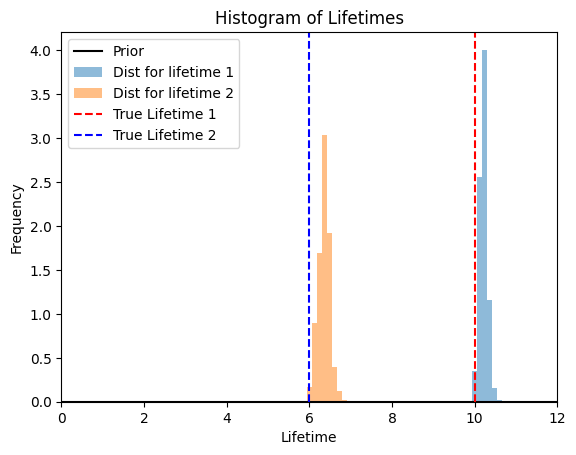

In [48]:
x = np.linspace(0,24,100)
plt.plot(x, np.exp(gamma_logprob(x,scale,1)),color='k', label = 'Prior')

for i in range(large_M):
  plt.hist(np.array(lam_samples)[-gibbs_iterations:, i], bins=np.linspace(0,12,100), alpha=0.5, label=('Dist for lifetime '+str(i+1)),density=True)

# Plot vertical lines at ground truth values
plt.axvline(x=lifetime1, color='r', linestyle='--', label='True Lifetime 1')
plt.axvline(x=lifetime2, color='b', linestyle='--', label='True Lifetime 2')

plt.xlim(0,12)

plt.xlabel('Lifetime')
plt.ylabel('Frequency')
plt.title('Histogram of Lifetimes')

plt.legend()
plt.show()

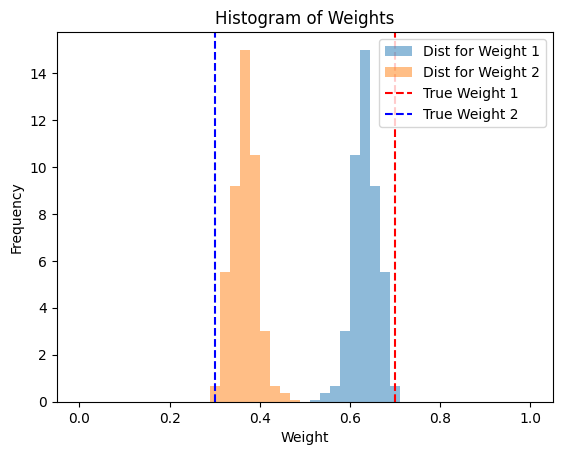

In [49]:
#Plot histograms of the sampled weights for each species
for i in range(large_M):
  plt.hist(np.array(pi_samples)[-gibbs_iterations:, i], bins=45, range=(0,1), alpha=0.5, label=('Dist for Weight '+str(i+1)),density=True)

# Plot vertical lines at ground truth values
plt.axvline(x=pi1, color='r', linestyle='--', label='True Weight 1')
plt.axvline(x=pi2, color='b', linestyle='--', label='True Weight 2')

plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')
plt.legend()
plt.show()

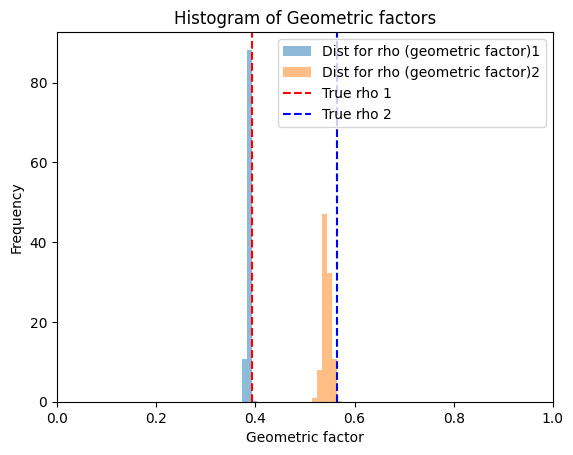

In [50]:

for i in range(large_M):
  plt.hist(lifetime2rho(np.array(lam_samples))[-gibbs_iterations:, i], bins=np.linspace(0,1,100), alpha=0.5, label=('Dist for rho (geometric factor)'+str(i+1)),density=True)

# Plot vertical lines at ground truth values
plt.axvline(x=rho1, color='r', linestyle='--', label='True rho 1')
plt.axvline(x=rho2, color='b', linestyle='--', label='True rho 2')

plt.xlim(0,1)

plt.xlabel('Geometric factor')
plt.ylabel('Frequency')
plt.title('Histogram of Geometric factors')

plt.legend()
plt.show()

/tmp/ipython-input-41-2931143798.py:9: RuntimeWarning: divide by zero encountered in log
  return -gammaln(alpha) - alpha * np.log(theta) + (alpha - 1) * np.log(x) - x / theta


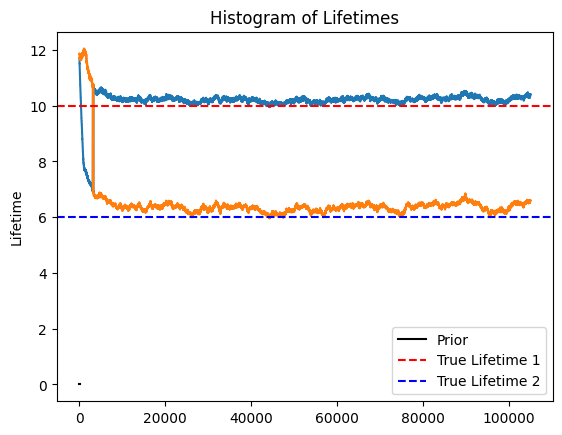

In [51]:
x = np.linspace(0,24,100)
plt.plot(x, np.exp(gamma_logprob(x,scale,1)),color='k', label = 'Prior')

for i in range(2):
  plt.plot(np.array(lam_samples)[:, i])

# Plot vertical lines at ground truth values
plt.axhline(lifetime1, color='r', linestyle='--', label='True Lifetime 1')
plt.axhline(lifetime2, color='b', linestyle='--', label='True Lifetime 2')



plt.ylabel('Lifetime')

plt.title('Histogram of Lifetimes')

plt.legend()
plt.show()